Starting Machine Learning Analysis for A/B Testing Data
Data loaded: 588101 rows, 6 columns
First look at the data:


,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,0,130,Monday,20
1,1119715,ad,0,93,Tuesday,22
2,1144181,ad,0,21,Tuesday,18
3,1435133,ad,0,355,Tuesday,10
4,1015700,ad,0,276,Friday,14



Converting boolean 'converted' column to integer...
Converted distribution:
converted
0    573258
1     14843
Name: count, dtype: int64

Preparing data for machine learning...
Creating engagement tiers...
Encoding categorical variables...
Encoded test_group: ['ad', 'psa']
Encoded most_ads_day: ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
Encoded ad_engagement: ['high', 'low', 'medium']

Features: ['test_group', 'total_ads', 'most_ads_hour', 'most_ads_day', 'ad_engagement']
Target: converted
Feature matrix shape: (588101, 5)
Target distribution:
converted
0    573258
1     14843
Name: count, dtype: int64

Training set: 411,670 samples
Test set: 176,431 samples
TRAINING RANDOM FOREST MODEL
Random Forest Results:
AUC Score: 0.8575

Feature Importance (Random Forest):


,feature,importance
1,total_ads,0.602816
4,ad_engagement,0.246573
2,most_ads_hour,0.086152
3,most_ads_day,0.054305
0,test_group,0.010154


TRAINING LOGISTIC REGRESSION MODEL
Logistic Regression Results:
AUC Score: 0.7273

Feature Importance (Logistic Regression - Absolute Coefficients):


,feature,importance
4,ad_engagement,0.927769
0,test_group,0.340968
2,most_ads_hour,0.031960
3,most_ads_day,0.016782
1,total_ads,0.005808


CREATING VISUALIZATIONS


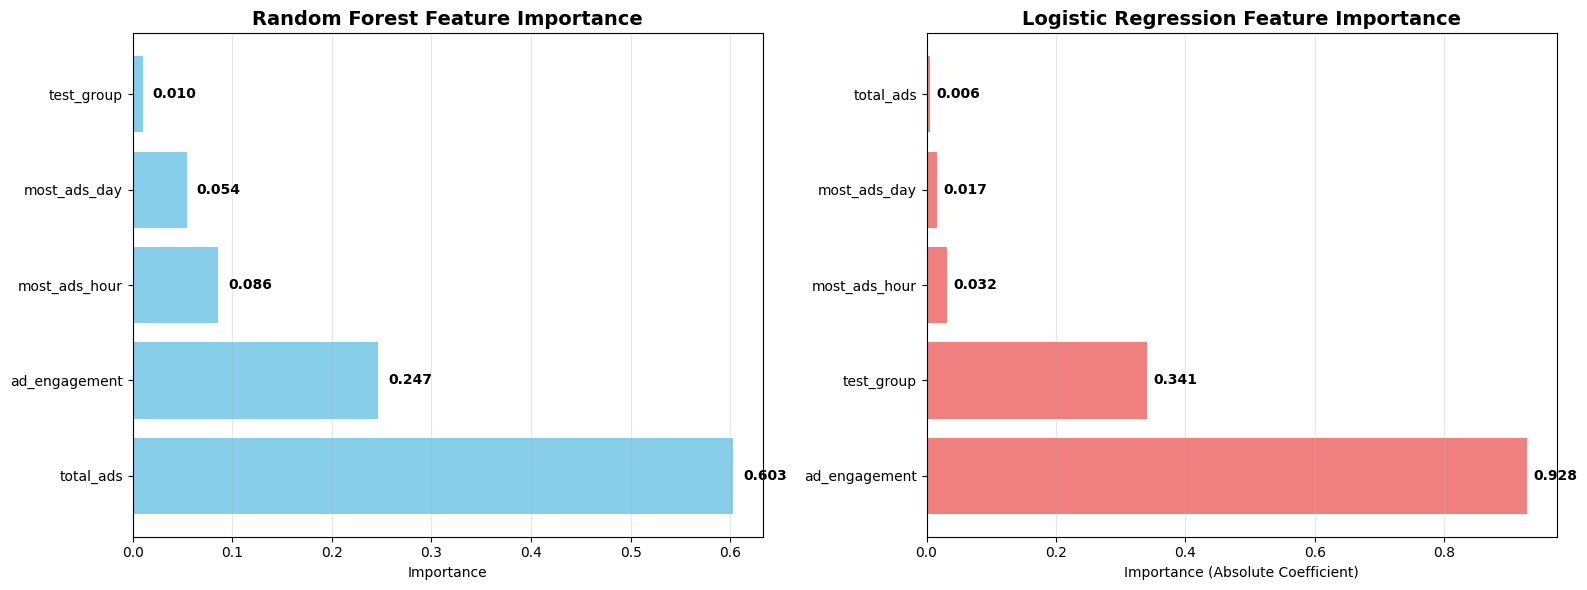

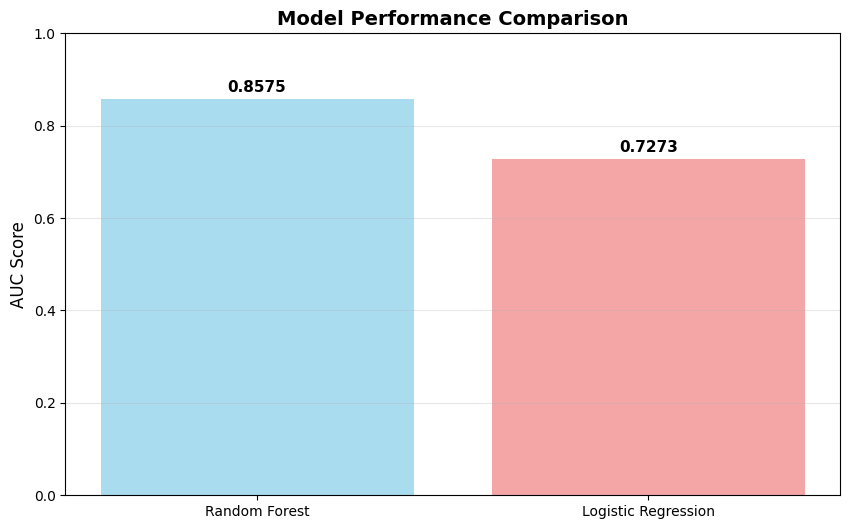

BUSINESS INSIGHTS SUMMARY

 BEST PERFORMING MODEL: Random Forest
 BEST AUC SCORE: 0.8575

 TOP CONVERSION DRIVERS (RANDOM FOREST):
   2. total_ads: 0.6028
   5. ad_engagement: 0.2466
   3. most_ads_hour: 0.0862
   4. most_ads_day: 0.0543
   1. test_group: 0.0102

 TOP CONVERSION DRIVERS (LOGISTIC REGRESSION):
   5. ad_engagement: 0.9278
   1. test_group: 0.3410
   3. most_ads_hour: 0.0320
   4. most_ads_day: 0.0168
   2. total_ads: 0.0058
GENERATING PREDICTIONS
Generating conversion probabilities for all users...

👥 TOP 10 USERS MOST LIKELY TO CONVERT:


,user_id,test_group_decoded,total_ads,conversion_probability
15334,1512157,psa,1491,0.632805
27800,1200489,psa,1354,0.562046
109775,900581,ad,543,0.544342
145332,909533,ad,290,0.518763
12849,1324104,psa,609,0.501288
29694,912450,ad,80,0.492739
60870,906354,ad,58,0.478087
5022,1165279,psa,1129,0.466847
173739,920177,ad,9,0.461205
299931,914202,ad,9,0.461205


PREDICTION SUMMARY STATISTICS
Average conversion probability: 0.0253
Median conversion probability: 0.0076
Std conversion probability: 0.0450
Max conversion probability: 0.6328
Min conversion probability: 0.0001


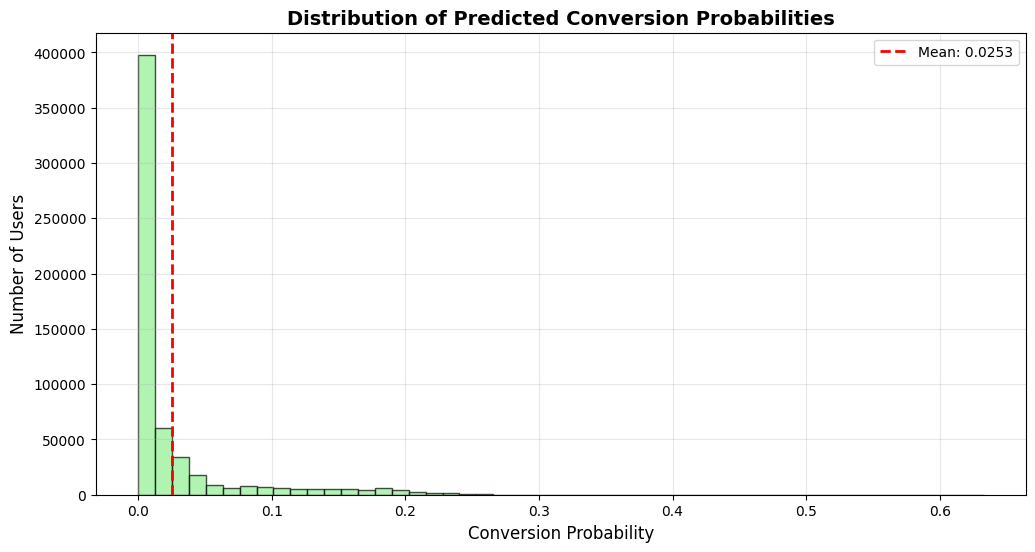

 Key Insight: User behavior (ad exposure, engagement) matters more than test group assignment!


In [7]:
# Build ML models to predict user conversions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

print("Starting Machine Learning Analysis for A/B Testing Data")

# Load the data
df = pd.read_csv('../data/marketing_AB_cleaned.csv')
print(f"Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print("First look at the data:")
display(df.head())

# Fix: Convert boolean converted column to integer
print("\nConverting boolean 'converted' column to integer...")
df['converted'] = df['converted'].astype(int)
print(f"Converted distribution:\n{df['converted'].value_counts()}")

# Data preparation for ML
print("\nPreparing data for machine learning...")

# Create a copy for ML
df_ml = df.copy()

# Feature engineering
# 1. Create engagement tiers based on total ads
print("Creating engagement tiers...")
df_ml['ad_engagement'] = df_ml['total_ads'].apply(
    lambda x: 'low' if x < 10 else 'medium' if x < 50 else 'high'
)

# 2. Encode categorical variables
print("Encoding categorical variables...")
categorical_columns = ['test_group', 'most_ads_day', 'ad_engagement']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df_ml[col] = le.fit_transform(df_ml[col].astype(str))
    label_encoders[col] = le
    print(f"Encoded {col}: {list(le.classes_)}")

# 3. Select features for modeling
feature_columns = ['test_group', 'total_ads', 'most_ads_hour', 'most_ads_day', 'ad_engagement']
target_column = 'converted'

print(f"\nFeatures: {feature_columns}")
print(f"Target: {target_column}")

# Prepare X and y
X = df_ml[feature_columns]
y = df_ml[target_column]

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

# Train Random Forest model

print("TRAINING RANDOM FOREST MODEL")


rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Calculate performance metrics
rf_auc = roc_auc_score(y_test, y_pred_proba_rf)

print("Random Forest Results:")
print(f"AUC Score: {rf_auc:.4f}")

# Feature importance
feature_importance_rf = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Random Forest):")
display(feature_importance_rf)

# Train Logistic Regression model

print("TRAINING LOGISTIC REGRESSION MODEL")


lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]
lr_auc = roc_auc_score(y_test, y_pred_proba_lr)

print("Logistic Regression Results:")
print(f"AUC Score: {lr_auc:.4f}")

# Feature importance for logistic regression (absolute coefficients)
feature_importance_lr = pd.DataFrame({
    'feature': feature_columns,
    'importance': np.abs(lr_model.coef_[0])
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Logistic Regression - Absolute Coefficients):")
display(feature_importance_lr)

# Visualizations

print("CREATING VISUALIZATIONS")


# 1. Feature importance comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest feature importance
features_rf = feature_importance_rf['feature']
importances_rf = feature_importance_rf['importance']

bars1 = ax1.barh(range(len(features_rf)), importances_rf, color='skyblue')
ax1.set_yticks(range(len(features_rf)))
ax1.set_yticklabels(features_rf)
ax1.set_xlabel('Importance')
ax1.set_title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add value labels on bars for Random Forest
for i, (bar, importance) in enumerate(zip(bars1, importances_rf)):
    ax1.text(importance + 0.01, i, f'{importance:.3f}', va='center', fontweight='bold')

# Logistic Regression feature importance
features_lr = feature_importance_lr['feature']
importances_lr = feature_importance_lr['importance']

bars2 = ax2.barh(range(len(features_lr)), importances_lr, color='lightcoral')
ax2.set_yticks(range(len(features_lr)))
ax2.set_yticklabels(features_lr)
ax2.set_xlabel('Importance (Absolute Coefficient)')
ax2.set_title('Logistic Regression Feature Importance', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add value labels on bars for Logistic Regression
for i, (bar, importance) in enumerate(zip(bars2, importances_lr)):
    ax2.text(importance + 0.01, i, f'{importance:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 2. Model performance comparison
models = ['Random Forest', 'Logistic Regression']
auc_scores = [rf_auc, lr_auc]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(models, auc_scores, color=['skyblue', 'lightcoral'], alpha=0.7)
ax.set_ylabel('AUC Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, auc_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
           f'{score:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.show()

# Business insights

print("BUSINESS INSIGHTS SUMMARY")


print(f"\n BEST PERFORMING MODEL: {models[np.argmax(auc_scores)]}")
print(f" BEST AUC SCORE: {max(auc_scores):.4f}")

print(f"\n TOP CONVERSION DRIVERS (RANDOM FOREST):")
for i, row in feature_importance_rf.iterrows():
    print(f"   {i+1}. {row['feature']}: {row['importance']:.4f}")

print(f"\n TOP CONVERSION DRIVERS (LOGISTIC REGRESSION):")
for i, row in feature_importance_lr.iterrows():
    print(f"   {i+1}. {row['feature']}: {row['importance']:.4f}")

# Predict conversion probabilities for all users

print("GENERATING PREDICTIONS")


print("Generating conversion probabilities for all users...")
all_predictions = rf_model.predict_proba(X)[:, 1]
df_ml['conversion_probability'] = all_predictions

# Decode test_group for better readability
test_group_decoder = {0: 'psa', 1: 'ad'}  # Based on label encoding
df_ml['test_group_decoded'] = df_ml['test_group'].map(test_group_decoder)

# Show users with highest conversion probability
print("\n👥 TOP 10 USERS MOST LIKELY TO CONVERT:")
top_users = df_ml.nlargest(10, 'conversion_probability')[
    ['user_id', 'test_group_decoded', 'total_ads', 'conversion_probability']
]
display(top_users)

# Summary statistics

print("PREDICTION SUMMARY STATISTICS")

print(f"Average conversion probability: {df_ml['conversion_probability'].mean():.4f}")
print(f"Median conversion probability: {df_ml['conversion_probability'].median():.4f}")
print(f"Std conversion probability: {df_ml['conversion_probability'].std():.4f}")
print(f"Max conversion probability: {df_ml['conversion_probability'].max():.4f}")
print(f"Min conversion probability: {df_ml['conversion_probability'].min():.4f}")

# Distribution of predictions
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(df_ml['conversion_probability'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
ax.set_xlabel('Conversion Probability', fontsize=12)
ax.set_ylabel('Number of Users', fontsize=12)
ax.set_title('Distribution of Predicted Conversion Probabilities', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

# Add vertical line for mean
mean_prob = df_ml['conversion_probability'].mean()
ax.axvline(mean_prob, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_prob:.4f}')
ax.legend()

plt.show()

print(" Key Insight: User behavior (ad exposure, engagement) matters more than test group assignment!")